![](https://i.imgur.com/Z6lY389.png)

# Introduction

Mental Health is a very important matter that only now is starting to arrise in our community. I worked on this dataset on the AINI Datathon in Belfast, but I wanted to take it further and properly take my time and analyse the numbers, hoping to find some interesting insights and also movements that companies take towards this matter.
 
That being said, let's get our hands dirty.

# I. Data and Preprocessing (cleaning, missing values, recoding)

I worked on the `2016 OSMI Mental Health in Tech Survey`. It had 1433 rows and 63 columns, lot's of missing data, lot's of not integrated data (gender for example was left an open question), lot's of countries but not consistent in number of respondents etc.

Sumarized, what I did below is:
* rename columns
* sex columns & company size recoded
* removed outliers from age
* missing value listwise deletion (for variables where missing observations were more than half) and simple imputation
* column encoding
* country filtering (remained only with the ones with more than 30 responses)
* create tech column with flag 1/0

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# Data import
survey_2016 = pd.read_csv('01.Mental Health.csv')


# ----------- CLEANING THE DATA -----------
# Column rename
renamed_columns = ['self_empl_flag', 'comp_no_empl', 'tech_comp_flag', 'tech_role_flag', 'mh_coverage_flag',
                  'mh_coverage_awareness_flag', 'mh_employer_discussion', 'mh_resources_provided', 'mh_anonimity_flag',
                  'mh_medical_leave', 'mh_discussion_neg_impact', 'ph_discussion_neg_impact', 'mh_discussion_cowork',
                  'mh_discussion_supervis', 'mh_eq_ph_employer', 'mh_conseq_coworkers', 'mh_coverage_flag2', 'mh_online_res_flag',
                  'mh_diagnosed&reveal_clients_flag', 'mh_diagnosed&reveal_clients_impact', 'mh_diagnosed&reveal_cowork_flag', 'mh_cowork_reveal_neg_impact',
                  'mh_prod_impact', 'mh_prod_impact_perc', 'prev_employers_flag', 'prev_mh_benefits', 'prev_mh_benefits_awareness',
                  'prev_mh_discussion', 'prev_mh_resources', 'prev_mh_anonimity', 'prev_mh_discuss_neg_conseq', 'prev_ph_discuss_neg_conseq',
                  'prev_mh_discussion_cowork', 'prev_mh_discussion_supervisor', 'prev_mh_importance_employer', 'prev_mh_conseq_coworkers',
                  'future_ph_specification', 'why/why_not', 'future_mh_specification', 'why/why_not2', 'mh_hurt_on_career', 'mh_neg_view_cowork',
                  'mh_sharing_friends/fam_flag', 'mh_bad_response_workplace', 'mh_for_others_bad_response_workplace', 'mh_family_hist',
                  'mh_disorder_past', 'mh_disorder_current', 'yes:what_diagnosis?', 'maybe:whats_your_diag', 'mh_diagnos_proffesional',
                  'yes:condition_diagnosed', 'mh_sought_proffes_treatm', 'mh_eff_treat_impact_on_work', 'mh_not_eff_treat_impact_on_work',
                  'age', 'sex', 'country_live', 'live_us_teritory', 'country_work', 'work_us_teritory', 'work_position', 'remote_flag']
survey_2016.columns = renamed_columns

# Sex column needs to be recoded (number of unique values = 70)
survey_2016['sex'].replace(to_replace = ['Male', 'male', 'Male ', 'M', 'm',
       'man', 'Cis male', 'Male.', 'male 9:1 female, roughly', 'Male (cis)', 'Man', 'Sex is male',
       'cis male', 'Malr', 'Dude', "I'm a man why didn't you make this a drop down question. You should of asked sex? And I would of answered yes please. Seriously how much text can this take? ",
       'mail', 'M|', 'Male/genderqueer', 'male ',
       'Cis Male', 'Male (trans, FtM)',
       'cisdude', 'cis man', 'MALE'], value = 1, inplace = True)

survey_2016['sex'].replace(to_replace = ['Female', 'female', 'I identify as female.', 'female ',
       'Female assigned at birth ', 'F', 'Woman', 'fm', 'f', 'Cis female ', 'Transitioned, M2F',
       'Genderfluid (born female)', 'Female or Multi-Gender Femme', 'Female ', 'woman', 'female/woman',
       'Cisgender Female', 'fem', 'Female (props for making this a freeform field, though)',
       ' Female', 'Cis-woman', 'female-bodied; no feelings about gender',
       'AFAB'], value = 2, inplace = True)

survey_2016['sex'].replace(to_replace = ['Bigender', 'non-binary', 'Other/Transfeminine',
       'Androgynous', 'Other', 'nb masculine',
       'none of your business', 'genderqueer', 'Human', 'Genderfluid',
       'Enby', 'genderqueer woman', 'mtf', 'Queer', 'Agender', 'Fluid',
       'Nonbinary', 'human', 'Unicorn', 'Genderqueer',
       'Genderflux demi-girl', 'Transgender woman'], value = 3, inplace = True)

# Recode Comp size & country columns (for ease when doing plots)
survey_2016['comp_no_empl'].replace(to_replace = ['More than 1000'], value = '>1000', inplace = True)
survey_2016['country_live'].replace(to_replace = ['United States of America'], value = 'USA', inplace = True)
survey_2016['country_live'].replace(to_replace = ['United Kingdom'], value = 'UK', inplace = True)
survey_2016['country_work'].replace(to_replace = ['United States of America'], value = 'USA', inplace = True)
survey_2016['country_work'].replace(to_replace = ['United Kingdom'], value = 'UK', inplace = True)

# Max age is 323, min age is 3.
# There are only 5 people that have weird ages (3yo, 15yo, or 99yo or 323 yo.) 
# These people will take the average age of the dataset (the correct calculated one, w/out outliers)
mean_age = survey_2016[(survey_2016['age'] >= 18) | (survey_2016['age'] <= 75)]['age'].mean()
survey_2016['age'].replace(to_replace = survey_2016[(survey_2016['age'] < 18) | (survey_2016['age'] > 75)]['age'].tolist(),
                          value = mean_age, inplace = True)

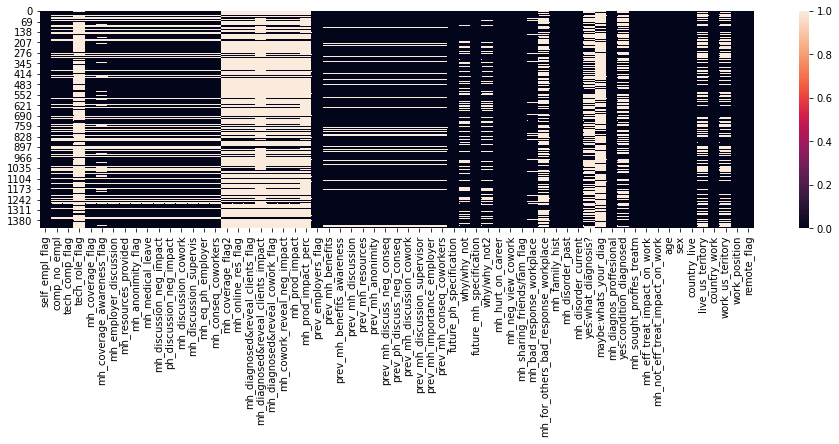

In [2]:
# ----------- MISSING VALUES -----------
# Missing values visualisation
plt.figure(figsize = (16,4))
sns.heatmap(data = survey_2016.isna());

In [3]:
# The survey has 1433 rows, so first we will drop all columns where more than half of the observations have missing values
cols = (survey_2016.isna().sum() >= survey_2016.shape[0]/2).tolist()
to_drop = survey_2016.columns[cols]
survey_2016.drop(labels = to_drop, axis = 1, inplace = True)

# Dealing with other missing values
from sklearn.impute import SimpleImputer

# Impute nan with the most frequent value (mode) on every row
imp = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imp.fit(survey_2016)
imp_data = pd.DataFrame(data = imp.transform(survey_2016), columns = survey_2016.columns)

In [6]:
# ----------- ENCODING -----------
# Split data into 2 datasets: one that needs to be encoded, one that doesnt need to
cols = [x for x in imp_data.columns if x not in ['age', 'why/why_not', 'why/why_not2', 'country_live',
       'live_us_teritory', 'country_work', 'work_us_teritory', 'work_position']]

data_to_encode = imp_data[cols]
data_not_encode = imp_data[['why/why_not', 'why/why_not2', 'country_live',
       'live_us_teritory', 'country_work', 'work_us_teritory', 'work_position']]

# Importing OneHotEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder

def encode(data):
    cat_columns = list(data.select_dtypes(include=['category','object']))
    column_mask = []
    
    for column_name in list(data.columns.values):
        column_mask.append(column_name in cat_columns)
    
    le = LabelEncoder()
    ohe = OneHotEncoder()
    
    for col in cat_columns:
        data[col] = le.fit_transform(data[col])
    data = ohe.fit_transform(data)
    
    return data

encode(data_to_encode)
matrix = encode(data_to_encode)
encoded_data = pd.DataFrame(matrix) # to dataframe
encoded_data.columns = data_to_encode.columns

# Preprocessed data
prep_data = pd.concat(objs = [encoded_data, data_not_encode], axis = 1)

ValueError: Length mismatch: Expected axis has 1 elements, new values have 42 elements

In [ ]:
# ----------- OTHER CHANGES -----------
# There are 53 total countries
# Out of all, most respondents are in US, UK, Canada, Germany, Netherlands and Australia.
# Usually, for a sample to be representative enough for the population, the size needs to be by convention >30.
# Respondents cannot be treated equaly within a response (different background, culture etc.), so we will exclude all nations
        #with a sample size smaller than 30. Because countries with no. responses > 30 are quite similar (well developed countries
        #with big economies and similar living standards), some of the analytics will incorporate all countries as one.

# Keep only countries with no. responses > 30.
imp_data = imp_data[imp_data['country_work'].isin(['USA', 'UK', 'Canada', 
                                                   'Germany', 'Netherlands','Australia'])]
imp_data = imp_data[imp_data['country_live'].isin(['USA', 'UK', 'Canada', 
                                                   'Germany', 'Netherlands','Australia'])]

prep_data = prep_data[prep_data['country_work'].isin(['USA', 'UK', 'Canada', 
                                                   'Germany', 'Netherlands','Australia'])]
prep_data = prep_data[prep_data['country_live'].isin(['USA', 'UK', 'Canada', 
                                                   'Germany', 'Netherlands','Australia'])]

# Unfortunatelly, the tech flag that identified if the respondent works/ doesn't work in tech had a lot of missing values
# So, we will need to map the 'work_position' column (that didn't have any missing values initially)
# Create the list with tech work positions
tech_list = []
tech_list.append(imp_data[imp_data['work_position'].str.contains('Back-end')]['work_position'].tolist())
tech_list.append(imp_data[imp_data['work_position'].str.contains('Front-end')]['work_position'].tolist())
tech_list.append(imp_data[imp_data['work_position'].str.contains('Dev')]['work_position'].tolist())
tech_list.append(imp_data[imp_data['work_position'].str.contains('DevOps')]['work_position'].tolist())

# Reshape the list (that is a list of lists) and remove duplicates
flat_list = [item for sublist in tech_list for item in sublist]
flat_list = list(dict.fromkeys(flat_list))

# Create a new column and recode it
imp_data['tech_flag'] = imp_data['work_position']
imp_data['tech_flag'].replace(to_replace = flat_list, value = 1, inplace = True)

# The other items - non tech
remain_list = imp_data['tech_flag'].unique()[1:].tolist()

imp_data['tech_flag'].replace(to_replace = remain_list, value = 0, inplace = True)

# The same for prep_data
# Create a new column and recode it
prep_data['tech_flag'] = prep_data['work_position']
prep_data['tech_flag'].replace(to_replace = flat_list, value = 1, inplace = True)

# The other items - non tech
prep_data['tech_flag'].replace(to_replace = remain_list, value = 0, inplace = True)

# II. Visualisation and Insights

Now let's get some learnings from the data:****

In [ ]:
import matplotlib as mpl
sns.set_style('whitegrid')
sns.set_palette('Set2')
mpl.rcParams['font.size'] = 16
import matplotlib.gridspec as gridspec

## Profile of the respondents

### 1.Teritory

Most respondents in the survey are in `Tech` (a relief, because only on them we will focus going further).
 
Also, most respondents are from the `US` and work in `medium or large companies`.

In [ ]:
# Most respondents are tech and also most of them are in US.
# Most techs are in medium and large companies
# For future analysis, we will exclude all people non-tech - as this analysis focuses on mental health in tech

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
plt.figure(figsize = (16,4))
fig.set_figheight(5)
fig.set_figwidth(20)
plt.subplots_adjust(wspace = 0)
# plt.suptitle('Main Title')

# No of respondents by Country
sns.countplot(x = imp_data['country_live'], hue = imp_data['tech_flag'], ax=ax1)
ax1.set_title('No. of Respondents by Country and tech_flag', fontsize = 20)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
ax1.set_xlabel('Country', fontsize = 18)
ax1.set_ylabel('Count', fontsize = 18)
ax1.legend(['Not in Tech', 'In Tech'])

# No of respondents by Company Size
sns.countplot(x = imp_data['comp_no_empl'], hue = imp_data['tech_flag'], ax=ax2, 
              order = ['1-5', '6-25', '26-100', '100-500', '500-1000', '>1000'])
ax2.set_title('No. of Respondents by Company Size and tech_flag', fontsize = 20)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=15, ha="right")
ax2.set_xlabel('Company Size', fontsize = 18)
ax2.set_ylabel('Count', fontsize = 18)
ax2.legend(['Not in Tech', 'In Tech']);

### 2. Gender (only techs) 
As expected, most of the respondents are `male`, this happening only because the tech industry is occupied by a big majority by men.

*As a side note, proportion of female in tech in this survey in US is the biggest one out of all countries. You go girl!*

In [ ]:
# Most respondents are male

plt.figure(figsize = (16,5))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(20)
plt.subplots_adjust(wspace = 0)
fig.suptitle('Proportions of genders in tech', fontsize = 25, y=1.08)

# Pie Chart
all_techs = imp_data[imp_data['tech_flag'] == 1]['sex'].count()
males = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['sex'] == 1.0)]['sex'].count()
females = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['sex'] == 2.0)]['sex'].count()
other = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['sex'] == 3.0)]['sex'].count()

labels = 'Male', 'Female', 'Other'
sizes = [males/all_techs, females/all_techs, other/all_techs]
colors = ['#73C6B6', '#F0B27A', '#7FB3D5']
explode = (0.03, 0, 0)  # explode 1st slice

ax2.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
ax2.axis('equal')
ax2.set_title('Overall gender prop%', pad = 20, fontsize = 20)

# Barchart
sns.countplot(x = imp_data[imp_data['tech_flag'] == 1]['country_live'], hue = imp_data['sex'], ax = ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
ax1.set_title('Gender by Countries', pad = 20, fontsize = 20)
ax1.set_xlabel('Country', fontsize = 18)
ax1.set_ylabel('Count', fontsize = 18)
ax1.legend(['Male', 'Female', 'Other']);

### 3.Age (only techs)

Distribution is skewed to the left, with the age of respondents being around `30-40 years old`, so quite young, but with enough work experience already.

In [ ]:
imp_data[imp_data['tech_flag'] == 1]['age'].describe()

## Insights from Techs 
### 1.Have / Had Mental Health Disorder

41% of the respondents confirm that they `have at the moment a mental health disorder`, while more than half of the respondents said that they `had a mental health disorder in the past`.

What is worring is the amount of respondents that answered "maybe" to this question, meaning a necessity to more support and guidance to identifying and addressing any issue that raised that "maybe" response in the first place.

In [ ]:
# ----------- NOW -----------

plt.figure(figsize = (16,5))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(20)
plt.subplots_adjust(wspace = 0)
fig.suptitle('Mental Health Disorder in Tech (in the present)', fontsize = 25, y=1.08)

# Pie Chart (Now)
all_techs_now = imp_data[imp_data['tech_flag'] == 1]['mh_disorder_current'].count()
no_now = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_disorder_current'] == 'No')]['mh_disorder_current'].count()
yes_now = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_disorder_current'] == 'Yes')]['mh_disorder_current'].count()
maybe_now = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_disorder_current'] == 'Maybe')]['mh_disorder_current'].count()

labels = 'No', 'Yes', 'Maybe'
sizes = [no_now/all_techs_now, yes_now/all_techs_now, maybe_now/all_techs_now]
colors = ['#73C6B6', '#F0B27A', '#7FB3D5']
explode = (0, 0.03, 0)  # explode 1st slice

ax2.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
ax2.axis('equal')
ax2.set_title('Overall MH prop% (NOW)', pad = 20, fontsize = 20)

# Barchart (now)
sns.countplot(x = imp_data[imp_data['tech_flag'] == 1]['country_live'], hue = imp_data['mh_disorder_current'], ax = ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
ax1.set_title('MH by Countries (NOW)', pad = 20, fontsize = 20)
ax1.set_xlabel('Country', fontsize = 18)
ax1.set_ylabel('Count', fontsize = 18)
ax1.legend();

In [ ]:
# ----------- PAST -----------

_ = plt.figure(figsize = (16,5))
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figheight(5)
fig.set_figwidth(20)
plt.subplots_adjust(wspace = 0)
fig.suptitle('Mental Health Disorder in Tech (in the past)', fontsize = 25, y=1.08)

# Pie Chart (Past)
all_techs_past = imp_data[imp_data['tech_flag'] == 1]['mh_disorder_current'].count()
no_past = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_disorder_past'] == 'No')]['mh_disorder_past'].count()
yes_past = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_disorder_past'] == 'Yes')]['mh_disorder_past'].count()
maybe_past = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_disorder_past'] == 'Maybe')]['mh_disorder_past'].count()

labels = 'No', 'Yes', 'Maybe'
sizes = [no_past/all_techs_past, yes_past/all_techs_past, maybe_past/all_techs_past]
colors = ['#73C6B6', '#F0B27A', '#7FB3D5']
explode = (0, 0.03, 0)  # explode 1st slice

ax2.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
ax2.axis('equal')
ax2.set_title('Overall MH prop% (PAST)', pad = 20, fontsize = 20)

# Barchart (Past)
sns.countplot(x = imp_data[imp_data['tech_flag'] == 1]['country_live'], hue = imp_data['mh_disorder_past'], ax = ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=15, ha="right")
ax1.set_title('MH by Countries (PAST)', pad = 20, fontsize = 20)
ax1.set_xlabel('Country', fontsize = 18)
ax1.set_ylabel('Count', fontsize = 18)
ax1.legend();

### 2.Are companies taking seriously Mental Health?

* From the averages in the survey, I would say `yes`, but not as much as it would be necessary. More than half of respondents have a Mental Health Coverage provided, but `not the resorces` of finding more information about this, meaning that most companies address mental health, but do not implicate themselves actively in it.

* More than 70% of respondents `do NOT know if their annonimity would be protected` in the case of talking to a superior about their mental health problems, while half of them are `not sure` that the company would grant them a mental health medical leave.

* Lastly, most respondents do not know if their company is `taking mental health problems as serious as physical health`. What is encouraging is that 94% of respondents do not think that there would be negative consequences for coworkers that experience mental health problems.

In [ ]:
mpl.rcParams['font.size'] = 13

fig, ax = plt.subplots(figsize = (16, 12), ncols=2, nrows=3)
plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top = 0.9, wspace=0, hspace = 0.3)
plt.suptitle('Are the Companies taking seriously mental health?', fontsize = 25, y = 1)

# Does your employer provide mental health benefits as part of healthcare coverage?
all_ = imp_data[imp_data['tech_flag'] == 1]['mh_coverage_flag'].count()
no_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_coverage_flag'] == 'No')]['mh_coverage_flag'].count()
yes_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_coverage_flag'] == 'Yes')]['mh_coverage_flag'].count()
not_know_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_coverage_flag'] == "I don't know")]['mh_coverage_flag'].count()
not_elig_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_coverage_flag'] == 'Not eligible for coverage / N/A')]['mh_coverage_flag'].count()

labels = 'No', 'Yes', 'Not Know', 'Not Elig.'
sizes = [no_/all_, yes_/all_, not_know_/all_, not_elig_/all_]
colors = ['#7FB3D5', '#73C6B6', '#F0B27A', '#C39BD3']
explode = (0, 0.03, 0, 0)  # explode 1st slice

ax[0][0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
ax[0][0].axis('equal')
ax[0][0].set_title('MH Coverage Provided', pad = 14, fontsize = 18)

# Does your employer offer resources to learn more about mental health concerns and options for seeking help?
all_ = imp_data[imp_data['tech_flag'] == 1]['mh_resources_provided'].count()
no_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_resources_provided'] == 'No')]['mh_resources_provided'].count()
yes_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_resources_provided'] == 'Yes')]['mh_resources_provided'].count()
not_know_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_resources_provided'] == "I don't know")]['mh_resources_provided'].count()

labels = 'No', 'Yes', 'Not Know'
sizes = [no_/all_, yes_/all_, not_know_/all_]
colors = ['#7FB3D5', '#73C6B6', '#F0B27A']
explode = (0.03, 0, 0)  # explode 1st slice

ax[0][1].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
ax[0][1].axis('equal')
ax[0][1].set_title('MH Resources Provided', pad = 14, fontsize = 18)

# Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?
all_ = imp_data[imp_data['tech_flag'] == 1]['mh_anonimity_flag'].count()
no_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_anonimity_flag'] == 'No')]['mh_anonimity_flag'].count()
yes_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_anonimity_flag'] == 'Yes')]['mh_anonimity_flag'].count()
not_know_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_anonimity_flag'] == "I don't know")]['mh_anonimity_flag'].count()

labels = 'No', 'Yes', 'Not Know'
sizes = [no_/all_, yes_/all_, not_know_/all_]
colors = ['#7FB3D5', '#73C6B6', '#F0B27A']
explode = (0, 0, 0.03)  # explode 1st slice

ax[1][0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
ax[1][0].axis('equal')
ax[1][0].set_title('MH Anonimity Provided', pad = 14, fontsize = 18)

# If a mental health issue prompted you to request a medical leave from work, asking for that leave would be:
all_ = imp_data[imp_data['tech_flag'] == 1]['mh_medical_leave'].count()
veasy_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_medical_leave'] == 'Very easy')]['mh_medical_leave'].count()
seasy_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_medical_leave'] == 'Somewhat easy')]['mh_medical_leave'].count()
middle_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_medical_leave'] == "Neither easy nor difficult")]['mh_medical_leave'].count()
vdiff_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_medical_leave'] == "Very difficult")]['mh_medical_leave'].count()
sdiff_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_medical_leave'] == "Somewhat difficult")]['mh_medical_leave'].count()
not_know_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_medical_leave'] == "I don't know")]['mh_medical_leave'].count()

labels = 'V Easy', 'S Easy', 'Middle', 'V Difficult', 'S Difficult', 'Not Know'
sizes = [veasy_/all_, seasy_/all_, middle_/all_, vdiff_/all_, sdiff_/all_, not_know_/all_]
colors = ['#7FB3D5', '#73C6B6', '#F0B27A', '#C39BD3', '#ABEBC6', '#F4D03F']
explode = (0, 0.03, 0, 0, 0, 0)  # explode 1st slice

ax[1][1].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
ax[1][1].axis('equal')
ax[1][1].set_title('MH Medical Leave Request', pad = 14, fontsize = 18)

# Do you feel that your employer takes mental health as seriously as physical health?
all_ = imp_data[imp_data['tech_flag'] == 1]['mh_eq_ph_employer'].count()
no_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_eq_ph_employer'] == 'No')]['mh_eq_ph_employer'].count()
yes_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_eq_ph_employer'] == 'Yes')]['mh_eq_ph_employer'].count()
not_know_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_eq_ph_employer'] == "I don't know")]['mh_eq_ph_employer'].count()

labels = 'No', 'Yes', 'Not Know'
sizes = [no_/all_, yes_/all_, not_know_/all_]
colors = ['#7FB3D5', '#73C6B6', '#F0B27A']
explode = (0, 0, 0.03)  # explode 1st slice

ax[2][0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
ax[2][0].axis('equal')
ax[2][0].set_title('Mental & Physical Health Equal Importance', pad = 14, fontsize = 18)

# Have you heard of or observed negative consequences for co-workers who have been open about mental health issues in your workplace?
all_ = imp_data[imp_data['tech_flag'] == 1]['mh_conseq_coworkers'].count()
no_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_conseq_coworkers'] == 'No')]['mh_conseq_coworkers'].count()
yes_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_conseq_coworkers'] == 'Yes')]['mh_conseq_coworkers'].count()

labels = 'No', 'Yes'
sizes = [no_/all_, yes_/all_]
colors = ['#7FB3D5', '#73C6B6']
explode = (0.08, 0)  # explode 1st slice

ax[2][1].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
ax[2][1].axis('equal')
ax[2][1].set_title('Neg. Conseq for Coworkers with MH Disorders', pad = 14, fontsize = 18);

fig.savefig('g06.jpg',bbox_inches = 'tight', facecolor='white')

### 3.Discussing Mental Health at Work

* 67% of respondents do not know or agree that there were `negative consequences about talking of Mental Health` with the Employer. There is also a big percentage of people that do not know if they would be relaxed of talking with the employer about mental health.

* Alarming is the percentage of people that think or actually know that `coworkers will view them badly` after confessing to having a mental health problem.

* Almost half of the respondents are `relaxed talking about mental health` with their supervisor.

In [ ]:
fig, ax = plt.subplots(figsize = (16, 8), ncols=2, nrows=2)
plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top = 0.9, wspace=0, hspace = 0.3)
plt.suptitle('Discussing Mental Health at Work', fontsize = 25, y = 1.04)

# Do you think that discussing a mental health disorder with your employer would have negative consequences?
all_ = imp_data[imp_data['tech_flag'] == 1]['mh_discussion_neg_impact'].count()
no_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_discussion_neg_impact'] == 'No')]['mh_discussion_neg_impact'].count()
yes_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_discussion_neg_impact'] == 'Yes')]['mh_discussion_neg_impact'].count()
maybe_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_discussion_neg_impact'] == 'Maybe')]['mh_discussion_neg_impact'].count()

labels = 'No', 'Yes', 'Not Know'
sizes = [no_/all_, yes_/all_, maybe_/all_]
colors = ['#7FB3D5', '#73C6B6', '#F0B27A']
explode = (0, 0, 0.03)  # explode 1st slice

ax[0][0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
ax[0][0].axis('equal')
ax[0][0].set_title('Neg Consequences after Discussing MH with Employer', pad = 14, fontsize = 14)

# Would you feel comfortable discussing a mental health disorder with your coworkers?
all_ = imp_data[imp_data['tech_flag'] == 1]['mh_discussion_cowork'].count()
no_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_discussion_cowork'] == 'No')]['mh_discussion_cowork'].count()
yes_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_discussion_cowork'] == 'Yes')]['mh_discussion_cowork'].count()
maybe_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_discussion_cowork'] == 'Maybe')]['mh_discussion_cowork'].count()

labels = 'No', 'Yes', 'Not Know'
sizes = [no_/all_, yes_/all_, maybe_/all_]
colors = ['#7FB3D5', '#73C6B6', '#F0B27A']
explode = (0, 0, 0.03)  # explode 1st slice

ax[0][1].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
ax[0][1].axis('equal')
ax[0][1].set_title('Are you relaxed of talking MHD with coworkers?', pad = 14, fontsize = 14)

# Do you think that team members/co-workers would view you more negatively if they knew you suffered from a mental health issue?
all_ = imp_data[imp_data['tech_flag'] == 1]['mh_neg_view_cowork'].count()
no_t = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_neg_view_cowork'] == "No, I don't think they would")]['mh_neg_view_cowork'].count()
no_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_neg_view_cowork'] == "No, they do not")]['mh_neg_view_cowork'].count()
maybe_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_neg_view_cowork'] == 'Maybe')]['mh_neg_view_cowork'].count()
yes_t = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_neg_view_cowork'] == 'Yes, I think they would')]['mh_neg_view_cowork'].count()
yes_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_neg_view_cowork'] == 'Yes, they do')]['mh_neg_view_cowork'].count()

labels = 'I think no', 'They do not', 'Maybe', 'I think yes', 'They do'
sizes = [no_t/all_, no_/all_, maybe_/all_, yes_t/all_, yes_/all_]
colors = ['#7FB3D5', '#73C6B6', '#F0B27A', '#C39BD3', '#ABEBC6']
explode = (0, 0, 0.03, 0, 0)  # explode 1st slice

ax[1][0].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
ax[1][0].axis('equal')
ax[1][0].set_title('You think coworkers will view you badly after confessing to a MHD?', pad = 14, fontsize = 14)

# Would you feel comfortable discussing a mental health disorder with your direct supervisor(s)?
all_ = imp_data[imp_data['tech_flag'] == 1]['mh_discussion_supervis'].count()
no_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_discussion_supervis'] == 'No')]['mh_discussion_supervis'].count()
yes_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_discussion_supervis'] == 'Yes')]['mh_discussion_supervis'].count()
maybe_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_discussion_supervis'] == 'Maybe')]['mh_discussion_supervis'].count()

labels = 'No', 'Yes', 'Not Know'
sizes = [no_/all_, yes_/all_, maybe_/all_]
colors = ['#7FB3D5', '#73C6B6', '#F0B27A']
explode = (0, 0.03, 0)  # explode 1st slice

ax[1][1].pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
ax[1][1].axis('equal')
ax[1][1].set_title('Are you relaxed of talking MHD with supervisors?', pad = 14, fontsize = 14);

fig.savefig('g07.jpg',bbox_inches = 'tight', facecolor='white')

### 4.Would Mental Health have consequences on my career?

Most people think or are certain that `having a Mental Health Disorder would hurt on your career`, but more than half of respondents `didn't either observed or experienced a bad response` to Mental Health around them.

These questions still show a `biaseness` about mental health and its actual real consequences on someones life.

In [ ]:
fig, (ax1, ax2) = plt.subplots(figsize = (16, 4), ncols=2, nrows=1)
plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top = 0.9, wspace=0, hspace = 0.3)
plt.suptitle('Is MH having bad consequences on career?', fontsize = 23, y = 1.1)

# Do you feel that being identified as a person with a mental health issue would hurt your career?
all_ = imp_data[imp_data['tech_flag'] == 1]['mh_hurt_on_career'].count()
no_t = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_hurt_on_career'] == "No, I don't think it would")]['mh_hurt_on_career'].count()
no_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_hurt_on_career'] == "No, it has not")]['mh_hurt_on_career'].count()
maybe_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_hurt_on_career'] == 'Maybe')]['mh_hurt_on_career'].count()
yes_t = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_hurt_on_career'] == 'Yes, I think it would')]['mh_hurt_on_career'].count()
yes_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_hurt_on_career'] == 'Yes, it has')]['mh_hurt_on_career'].count()

labels = 'I think no', 'It has not', 'Maybe', 'I think yes', 'Yes it has'
sizes = [no_t/all_, no_/all_, maybe_/all_, yes_t/all_, yes_/all_]
colors = ['#7FB3D5', '#73C6B6', '#F0B27A', '#C39BD3', '#ABEBC6']
explode = (0, 0, 0.03, 0, 0)  # explode 1st slice

ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
ax1.axis('equal')
ax1.set_title('You think being a person with MHD can hurt your career?', pad = 14, fontsize = 14)

# Have you observed or experienced an unsupportive or badly handled response to a mental health issue in your current or previous workplace?
all_ = imp_data[imp_data['tech_flag'] == 1]['mh_bad_response_workplace'].count()
no_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_bad_response_workplace'] == "No")]['mh_bad_response_workplace'].count()
maybe_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_bad_response_workplace'] == 'Maybe/Not sure')]['mh_bad_response_workplace'].count()
yes_e = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_bad_response_workplace'] == 'Yes, I experienced')]['mh_bad_response_workplace'].count()
yes_o = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_bad_response_workplace'] == 'Yes, I observed')]['mh_bad_response_workplace'].count()

labels = 'No', 'Maybe/Not sure', 'Yes, I experienced', 'Yes, I observed'
sizes = [no_/all_, maybe_/all_, yes_e/all_, yes_o/all_]
colors = ['#7FB3D5', '#73C6B6', '#F0B27A', '#C39BD3']
explode = (0.03, 0, 0, 0)  # explode 1st slice

ax2.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
ax2.axis('equal')
ax2.set_title('Have you observed/experienced badly response to a MHD?', pad = 14, fontsize = 14);

### 5.Being open about Mental Health with friends and family

* 63% of respondents are `open or somewhat open` about talking mental health with friends or family.
* Almost 20% of respondents are `not that confortable talking about mental health` with close ones, while the rest remain neutral.

In [ ]:
plt.figure(figsize = (16, 5))

# How willing would you be to share with friends and family that you have a mental illness?
all_ = imp_data[imp_data['tech_flag'] == 1]['mh_sharing_friends/fam_flag'].count()
na_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_sharing_friends/fam_flag'] == "Not applicable to me (I do not have a mental illness)")]['mh_sharing_friends/fam_flag'].count()
not_open_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_sharing_friends/fam_flag'] == 'Not open at all')]['mh_sharing_friends/fam_flag'].count()
somewhat_no = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_sharing_friends/fam_flag'] == 'Somewhat not open')]['mh_sharing_friends/fam_flag'].count()
neutral_ = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_sharing_friends/fam_flag'] == 'Neutral')]['mh_sharing_friends/fam_flag'].count()
somewhat_o = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_sharing_friends/fam_flag'] == 'Somewhat open')]['mh_sharing_friends/fam_flag'].count()
very_o = imp_data[(imp_data['tech_flag'] == 1) & (imp_data['mh_sharing_friends/fam_flag'] == 'Very open')]['mh_sharing_friends/fam_flag'].count()

labels = 'NA to me', 'Not open at all', 'Somewhat not open', 'Neutral', 'Somewhat open', 'Very open'
sizes = [na_/all_, not_open_/all_, somewhat_no/all_, neutral_/all_, somewhat_o/all_, very_o/all_]
colors = ['#7FB3D5', '#73C6B6', '#F0B27A', '#C39BD3', '#ABEBC6', '#F4D03F']
explode = (0, 0, 0, 0, 0.03, 0)  # explode 1st slice

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=False, startangle=140)
plt.axis('equal')
plt.title('How willing would you be to share with friends/family that you have a MHD?', pad = 14, fontsize = 20);

## US Map
### Percentages of people with Mental Health Disorders out of all respondents

*The data for each state is fluctuant and quite small, so the following information in the map should be taken with a grain of salt*

In [ ]:
# Preparing the data

# Create the table
table0 = imp_data[(imp_data['country_work'] == 'USA') & (imp_data['tech_flag'] == 1)].groupby(by = ['work_us_teritory', 'mh_disorder_current'])['self_empl_flag'].count().reset_index()
table1 = table0.pivot(index = 'work_us_teritory', columns = 'mh_disorder_current', values = 'self_empl_flag').reset_index()

# Deal with all NaN (setting them to 0)
table1.fillna(0, inplace = True)

# Calculate a prop column
table1['prop'] = table1['Yes'] / (table1['Maybe'] + table1['No'] + table1['Yes']) * 100
table1.rename(columns = {'work_us_teritory' : 'State'}, inplace = True)

# Add State Codes
codes = pd.read_csv('../input/usa-information/states.csv')
table2 = pd.merge(left = table1, right=codes, how = 'inner', on = 'State') #we lost none of the data :)

# Final table
df = table2[['State', 'Abbreviation', 'prop']]

# Creating the map

import plotly.graph_objects as go

fig = go.Figure(data=go.Choropleth(
    locations=df['Abbreviation'], # Spatial coordinates
    z = df['prop'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Blues',
    colorbar_title = "Percentage(%)",
    text = df['State'],
    marker_line_color='lightgray',
    marker_line_width=1
))

fig.update_layout(
    title_text = 'Percentage of people with MHD in every state (from total respondents)',
    geo_scope='usa', # limite map scope to USA
)

# III. Machine Learning - Making Predictions
## Predicting the "has_current_mental_health_disorder" variable

### 0.Imports

In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing

### 1.Data Preparing

In [ ]:
# Excluding non numeric columns from dataset
model_data = prep_data.copy()
col_numeric = [cols for cols in model_data.columns if model_data[cols].dtype in ['int64', 'float64']]
model_data = model_data[col_numeric]

# Model data is our new dataset for predicting variable 'mh_disorder_current'

# Feature variables and target variable
y = model_data['mh_disorder_current']

cols = [col for col in model_data.columns if col not in ['mh_disorder_current']]
X = model_data[cols]

# Data Validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### 2.Models

In [ ]:
# Predefined function
def model_assess(model, name='Default'):
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print('---', name, '---', '\n',
          confusion_matrix(y_test, preds), '\n',
          'Accuracy:', round(accuracy_score(y_test, preds), 5), '\n')

In [ ]:
# Naive Bayes
nb = GaussianNB()
model_assess(nb, name='Naive Bayes')

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_assess(sgd, name='SGD')

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_assess(knn, name='KNN')

# Decission trees
tree = DecisionTreeClassifier()
model_assess(tree, 'Decission Trees')

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_assess(rforest, 'Random Forest')

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_assess(svm, 'SVM')

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_assess(lg, 'Logistic Regression')

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(150, 10), random_state=1)
model_assess(nn, 'Neural Nets')

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_assess(xgb, 'XGBoost')

# Cross Gradient Booster (Random Forest) <=================== BEST
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_assess(xgbrf, 'XGBoost RF')

### 3.Parameter tunning for Cross Gradient Booster (random Forests)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Grid Search Function
def gridSearch(parameters):
    gsearch = GridSearchCV(estimator = XGBRFClassifier(learning_rate =0.00001,n_estimators=1000,max_depth=1,min_child_weight=4,
                                                    gamma=0.3,subsample=0.8,colsample_bytree=0.8,objective= 'multi:softmax',
                                                    nthread=4,scale_pos_weight=1), 
                        param_grid = parameters, cv=5)
    gsearch.fit(X_train,y_train)
    print('best params:', gsearch.best_params_)
    predictions = gsearch.predict(X_test)
    print('Accuracy:', round(accuracy_score(y_test, predictions), 5))

In [ ]:
param_test1 = {
 'min_child_weight':[1, 2, 3, 4]
}

gridSearch(param_test1)

In [ ]:
param_test2 = {
 'gamma':[i/10.0 for i in range(0,5)]
}

gridSearch(param_test2)

In [ ]:
param_test3 = {
 'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gridSearch(param_test3)

In [ ]:
param_test5 = {
 'learning_rate':[1e-5, 1e-2, 0.1, 1, 100]
}

gridSearch(param_test5)

In [ ]:
# Final Model
xgbrf_tuned = XGBRFClassifier(objective= 'multi:softmax', learning_rate =0.00001, n_estimators=1000, max_depth=1, 
                              min_child_weight=5,gamma = 0.3, subsample=0.8, colsample_bytree=0.9, 
                              nthread=4, scale_pos_weight=1)
model_assess(xgbrf_tuned)

So the best Accuracy is 0.79784.

We notice that value 0 (no MH) has the most failed predictions, but values 1 and 2 (yes MH and Maybe) have very high accuracies (for yes is 81% and for Maybe is 91%)

Because in a future query we would like to assess if the person has (or thinks they have) a MH dissorder, we can confirm that the model is good and we can go further with it.

## Bonus: Feature Importance

In [ ]:
# How important is each variable into predicting if the respondent has a current Mental Health Problem?

import eli5
from eli5.sklearn import PermutationImportance

perm = PermutationImportance(estimator=xgbrf_tuned, random_state=1)
perm.fit(X_test, y_test)

eli5.show_weights(estimator=perm, feature_names = X_test.columns.tolist())

In [ ]:
# Creating new train datasets only with features that have an importance bigger than 0.004
X_train_new = X_train[['mh_disorder_past', 'mh_not_eff_treat_impact_on_work', 'mh_diagnos_proffesional', 
                       'mh_eff_treat_impact_on_work']]
X_test_new = X_test[['mh_disorder_past', 'mh_not_eff_treat_impact_on_work', 'mh_diagnos_proffesional', 
                       'mh_eff_treat_impact_on_work']]

# Fitting the model to the new train datasets to see if we get a better accuracy
xgbrf_perm_imp = XGBRFClassifier(objective= 'multi:softmax', learning_rate =0.00001, n_estimators=1000, max_depth=1, 
                              min_child_weight=5,gamma = 0.3, subsample=0.8, colsample_bytree=0.9, 
                              nthread=4, scale_pos_weight=1)
xgbrf_perm_imp.fit(X_train_new, y_train)
predictions = xgbrf_perm_imp.predict(X_test_new)
print(confusion_matrix(y_test, predictions))
print('Accuracy:', accuracy_score(y_test, predictions))

The accuracy is slightly worse than the one we got before, but it is very good to know that using only 4 feature columns from the survey out of the 42 it is enough to create a very similar model with almost the same performance.

### Plotting feature Importance

In [ ]:
from xgboost import plot_tree, plot_importance

fig, (ax1, ax2) = plt.subplots(figsize = (13, 8), ncols=1, nrows=2)
plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top = 0.9, wspace=0, hspace = 0.5)

plot_importance(xgbrf_tuned, importance_type='gain', ax = ax1)
ax1.set_title('Feature Importance by Information Gain', fontsize = 18)
ax1.set_xlabel('Gain')

plot_importance(xgbrf_tuned, importance_type='weight', ax = ax2)
ax2.set_title('Feature Importance by Weight', fontsize = 18)
ax2.set_xlabel('Weight');

# Conclusions

In my opinion, the openess of companies and people in general to mental health in tech is a bit stronger than I would have anticipated, but there is still lots of room for improvement.

The amount of people that are not sure or are certain of future negative consequences, in the workplace or at home after talking about their mental health is still too big to be ignored.

There is also some biast thoughts among the respondents, mental health disorders still being viewed with a stiff mentality, when in reality people are starting to pay much more attention and being more accepting to it.


<div class="alert alert-block alert-info">
<p>If you liked this, please upvote! 😁<p>
<b>Cheers!<b>
</div>